# Load Libraries

In [ ]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
EMBEDDING_DIM = 100
MAX_LENGTH = 32
TRAINING_SPLIT = 0.9
BATCH_SIZE = 128

The dataset is [Sentiment140 dataset](https://www.tensorflow.org/datasets/catalog/sentiment140), which contains 1.6 million tweets alongside their respective sentiment (0 for negative and 4 for positive).

In [ ]:
data_path = "./data/training_cleaned.csv"
df = pd.read_csv(data_path, header=None)
df.head()

,0,1,2,3,4,5
0,4,1972002925,Sat May 30 08:21:22 PDT 2009,NO_QUERY,noobpwned,Started my morning off with a bloody nose. H...
1,0,2013837538,Tue Jun 02 23:42:53 PDT 2009,NO_QUERY,missjnz,@lawrencebrown must be a sign you need a holi...
2,0,1992941765,Mon Jun 01 09:34:24 PDT 2009,NO_QUERY,cupcake147,omg i have to go to summer school!
3,4,2054702495,Sat Jun 06 07:54:59 PDT 2009,NO_QUERY,heya10,Getting ready to go skydiving. How exciting to...
4,0,2030659197,Thu Jun 04 08:41:44 PDT 2009,NO_QUERY,Sciteg,As i read a few minutes ago... the visit of Ob...


## Explore the dataset

The dataset is provided in a csv file.

Each row of this file contains the following values separated by commas:

- target: the polarity of the tweet (0 = negative, 4 = positive)

- ids: The id of the tweet

- date: the date of the tweet

- flag: The query. If there is no query, then this value is NO_QUERY.

- user: the user that tweeted

- text: the text of the tweet


In [ ]:
# Standardize labels so they have 0 for negative and 1 for positive
labels = df[0].apply(lambda x: 0 if x == 0 else 1).to_numpy()

# Since the original dataset does not provide headers you need to index the columns by their index
sentences = df[5].to_numpy()

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

# Get the first 5 elements of the dataset
examples = list(dataset.take(5))

print(f"dataset contains {len(dataset)} examples\n")

print(f"Text of second example look like this: {examples[1][0].numpy().decode('utf-8')}\n")
print(f"Labels of first 5 examples look like this: {[x[1].numpy() for x in examples]}")

dataset contains 160000 examples

Text of second example look like this: @lawrencebrown  must be a sign you need a holiday !

Labels of first 5 examples look like this: [1, 0, 0, 1, 0]


## train_val_datasets

In [ ]:
# GRADED FUNCTION: train_val_datasets

def train_val_datasets(dataset):
    """
    Splits the dataset into training and validation sets, after shuffling it.

    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with elements as (sentence, label)

    Returns:
        (tf.data.Dataset, tf.data.Dataset): tuple containing the train and validation datasets
    """

    # Shuffle the dataset (buffer size = dataset size to ensure full shuffle)
    dataset = dataset.shuffle(buffer_size=len(dataset))

    # Compute the number of elements for training
    dataset_size = len(dataset)
    train_size = int(dataset_size * TRAINING_SPLIT)

    # Split the dataset
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size)

    # Batch the datasets
    train_dataset = train_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)

    return train_dataset, validation_dataset

In [ ]:
# Create the train and validation datasets
train_dataset, validation_dataset = train_val_datasets(dataset)

print(f"There are {len(train_dataset)} batches for a total of {BATCH_SIZE*len(train_dataset)} elements for training.\n")
print(f"There are {len(validation_dataset)} batches for a total of {BATCH_SIZE*len(validation_dataset)} elements for validation.\n")

There are 1125 batches for a total of 144000 elements for training.

There are 125 batches for a total of 16000 elements for validation.



## fit_vectorizer


In [ ]:
def fit_vectorizer(dataset):
    """
    Adapts the TextVectorization layer on the training sentences

    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with training sentences.

    Returns:
        tf.keras.layers.TextVectorization: an instance of the TextVectorization class adapted to the training sentences.
    """

    # Instantiate the TextVectorization layer
    vectorizer = tf.keras.layers.TextVectorization(
        standardize='lower_and_strip_punctuation',
        max_tokens=None,
        output_mode='int',
        output_sequence_length=MAX_LENGTH
    )

    # Fit (adapt) the vectorizer on the sentences
    vectorizer.adapt(dataset)

    return vectorizer

In [ ]:
# Get only the texts out of the dataset
text_only_dataset = train_dataset.map(lambda text, label: text)

# Adapt the vectorizer to the training sentences
vectorizer = fit_vectorizer(text_only_dataset)

# Check size of vocabulary
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 145760 words



In [ ]:
# Apply vectorization to train and val datasets
train_dataset_vectorized = train_dataset.map(lambda x,y: (vectorizer(x), y))
validation_dataset_vectorized = validation_dataset.map(lambda x,y: (vectorizer(x), y))

### Using pre-defined Embeddings

In [ ]:
# Define path to file containing the embeddings
glove_file = './data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
glove_embeddings = {}

# Read file and fill glove_embeddings with its contents
with open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

In [ ]:
test_word = 'dog'

test_vector = glove_embeddings[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

In [ ]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


In [ ]:
# Create a word index dictionary
word_index = {x:i for i,x in enumerate(vectorizer.get_vocabulary())}

print(f"The word dog is encoded as: {word_index['dog']}")

The word dog is encoded as: 503


In [ ]:
# Initialize an empty numpy array with the appropriate size
embeddings_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the embeddings_matrix array
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [ ]:
test_word = 'dog'

test_word_id = word_index[test_word]

test_vector_dog = glove_embeddings[test_word]

test_embedding_dog = embeddings_matrix[test_word_id]

both_equal = np.allclose(test_vector_dog,test_embedding_dog)

print(f"word: {test_word}, index: {test_word_id}\n\nEmbedding is equal to column {test_word_id} in the embeddings_matrix: {both_equal}")

word: dog, index: 503

Embedding is equal to column 503 in the embeddings_matrix: True


## create_model

In [1]:
def create_model(vocab_size, pretrained_embeddings):
    """
    Creates a binary sentiment classifier model

    Args:
        vocab_size (int): Number of words in the vocabulary.
        pretrained_embeddings (np.ndarray): Array containing pre-trained embeddings.

    Returns:
        (tf.keras Model): the sentiment classifier model
    """
    embedding_dim = pretrained_embeddings.shape[1]

    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[pretrained_embeddings],
        trainable=False
    ),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Create your untrained model
model = create_model(vocab_size, embeddings_matrix)

# Check parameter count against a reference solution
unittests.parameter_count(model)

Your model has 14,648,449 total parameters and the reference is 15,000,000. You are good to go!

Your model has 72,449 trainable parameters and the reference is 35,000
Warning! this exceeds the reference which is 35,000. If the kernel crashes while training, switch to a simpler architecture.


In [ ]:
# Take an example batch of data
example_batch = train_dataset_vectorized.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

I0000 00:00:1748606383.711424     228 service.cc:145] XLA service 0x7400cc006170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748606383.711555     228 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1748606384.279193     228 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


predictions have shape: (128, 1)


In [ ]:
# Train the model and save the training history
history = model.fit(
	train_dataset_vectorized,
	epochs=20,
	validation_data=validation_dataset_vectorized
)

Epoch 1/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6580 - loss: 0.6122 - val_accuracy: 0.7538 - val_loss: 0.5093
Epoch 2/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7396 - loss: 0.5219 - val_accuracy: 0.7741 - val_loss: 0.4803
Epoch 3/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7543 - loss: 0.5005 - val_accuracy: 0.7861 - val_loss: 0.4732
Epoch 4/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7625 - loss: 0.4868 - val_accuracy: 0.7871 - val_loss: 0.4709
Epoch 5/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7664 - loss: 0.4810 - val_accuracy: 0.7996 - val_loss: 0.4510
Epoch 6/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7752 - loss: 0.4697 - val_accuracy: 0.8049 - val_loss: 0.4386
Epoch 7/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7785 - loss: 0.4643 - val_accuracy: 0.8034 - val_loss: 0.4415
Epoch 8/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7811 - loss: 0.4584 - 

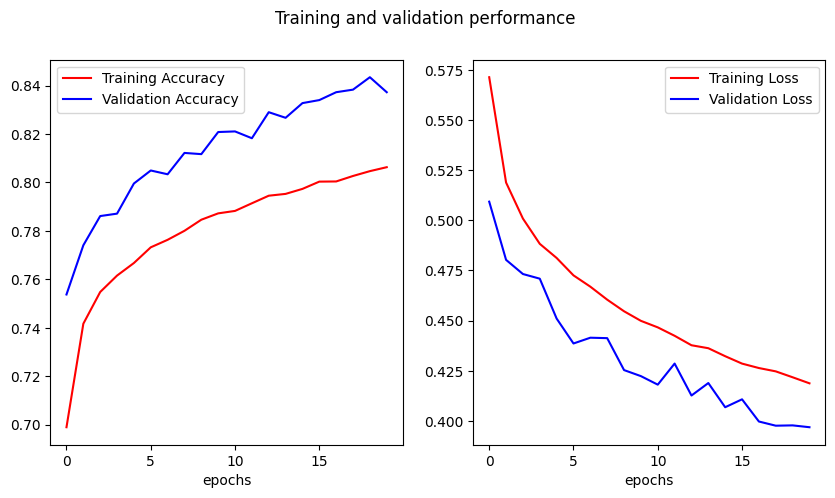

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

The image displays two plots showing the training and validation performance of a machine learning model over epochs. The left plot illustrates the accuracy, where both training and validation accuracy increase with epochs, with the validation accuracy generally staying slightly below the training accuracy but showing a good trend of improvement and eventual plateauing. The right plot shows the loss, where both training and validation loss decrease over epochs, with the validation loss initially higher but converging towards the training loss and also plateauing. Overall, the graphs suggest a good fit without significant overfitting, as the validation metrics follow the training metrics closely and stabilize, indicating that the model is learning and generalizing well to unseen data.